In this notebook, I am implementing the Discrete Fourier Transform via correlation (i.e. not with Fast Fourier Transform algorithm) and demonstrate its use on randomly generated signals.

Let's start out with importing a few libraries I'll need, seed the random number generator, and set a constant for the signal length.

In [37]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt

%matplotlib inline

rnd.seed(111)        # to ensure reproducibility

SIGNAL_LENGTH = 64   # a fairly short length but sufficient to experiment with the DFT
                     # a bit; computing the DFT via correlation becomes inefficient
                     # anyway for larger signals

Now I will generate two random signals and visualize them to start off.

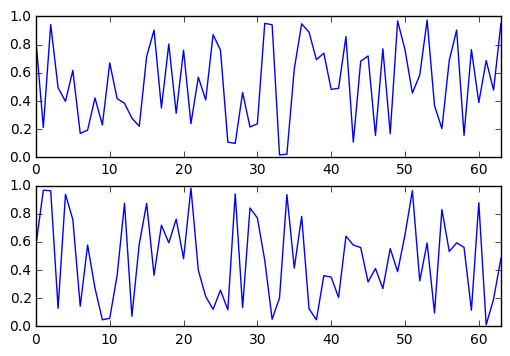

In [38]:
signal_a = [rnd.random() for i in range(SIGNAL_LENGTH)]
signal_b = [rnd.random() for i in range(SIGNAL_LENGTH)]

plt.subplot(2, 1, 1)
plt.plot(signal_a)
plt.xlim(0, SIGNAL_LENGTH-1)

plt.subplot(2, 1, 2)
plt.plot(signal_b)
plt.xlim(0, SIGNAL_LENGTH-1)

plt.show()

Now what the Discrete Fourier Transform (DFT from now on) does, is to decompose a signal into a number of basis functions of different frequencies. The basis functions of the DFT are sine and cosine wave functions each with a specific amplitude. To compute these amplitudes for each sine/cosine function, one can, for example, correlate the input signal with each such basis function. So I will need a function to do that:

In [39]:
def correlate(signal_a, signal_b):
    accum = 0
    # the signals are assumed to be of equal length
    # which, in the context of the DFT, will always
    # hold since the cosine and sine wave functions
    # are by definition of the same length as the
    # original input signal
    for i in range(len(signal_a)):
        accum += signal_a[i] * signal_b[i]
    return(accum)

(Note that this function computes cross-correlation (https://en.wikipedia.org/wiki/Cross-correlation), not the correlation known from statistics (https://en.wikipedia.org/wiki/Correlation_and_dependence).)

The "trick" of why the DFT can be computed (and thus the amplitudes for the basis functions be found) by cross-correlating the input signal with each individual basis function works because the basis functions are orthogonal to each other. Put differently, cosine functions of different frequencies have a cross-correlation of 0. 

Let's see if this is indeed the case.

(0, 63)

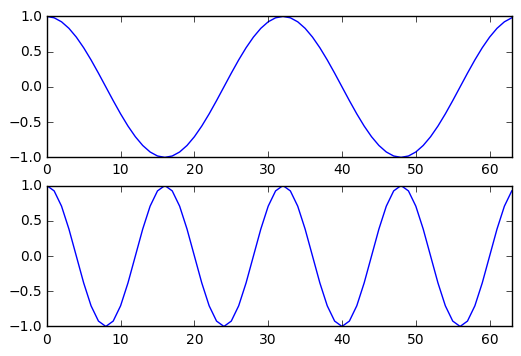

In [40]:
cos_a = [np.cos(2 * np.pi * 2 * n/SIGNAL_LENGTH) for n in range(SIGNAL_LENGTH)]
cos_b = [np.cos(2 * np.pi * 4 * n/SIGNAL_LENGTH) for n in range(SIGNAL_LENGTH)]

plt.subplot(2, 1, 1)
plt.plot(cos_a)
plt.xlim(0, SIGNAL_LENGTH-1)

plt.subplot(2, 1, 2)
plt.plot(cos_b)
plt.xlim(0, SIGNAL_LENGTH-1)

The two plots show two cosine functions, the top one with a frequency of 2, the lower one with a frequency of 4. Both of these would be part of the basis functions of an input signal with length >= 8. What is the value of their cross-correlation?

In [41]:
correlate(cos_a, cos_b)

-4.6629367034256575e-15

It's as good as 0; the reason why it is not exactly equal to 0 is because of floating point arithmetic. This will be the case for all pairs of cosine and sine functions respectively.

To understand DFT-via-correlation, one now has to keep in mind that:
i) any input signal can be decomposed into a number of finite cosine and sine functions;
ii) (co-)sine functions with different frequencies are pairwise-orthogonal;
iii) thanks to superposition, these two things are equivalent: a) decomposing a signal into basis functions, correlating each of them with another signal, and adding them back together, and b) correlating the input signal directly with a basis function.

So, if one correlates the input signal with a basis function, it is equivalent to correlating all basis functions of the input signal with that one basis function which yields 0, due to them being orthogonal, for all functions except the one we are correlating the input signal with! Said more concretely, correlating an input signal with a cosine function with frequency 3 will yield 0 for all (hypothetical, at this point) other cosine basis functions that the input signal is composed of except the one with frequency 3. Doing this for all relevant frequencies gives, for each, the amplitude of that basis function in the input signal.

This is what the following DFT() function does:

In [42]:
def basis_function(function, frequency, signal_length):
    # 2 * np.pi corresponds to one period of the wave function;
    # frequency corresponds to how many of those periods
    # the wave function completes over the length of the 
    # input signal; and n/signal_length corresponds to "how far"
    # the wave function has gotten into its frequency-many
    # periods at the point n in the signal
    values = [function(2 * np.pi * frequency * (n/signal_length))
              for n in range(signal_length)]
    # the result is returned as an np.array since this
    # makes multiplication with the amplitude contained
    # in ReX and ImX easier programmatically
    return(np.array(values))

def DFT(signal):
    # this implementation of the Discrete Fourier Transform
    # calculates the component signals via correlation of
    # each basis function with the original input signal;
    # note that this implementation is not using complex
    # numbers to represent the amplitudes. this will be 
    # done further down. it does, however, already use
    # ReX, ImX as variables that will later correspond
    # to the real and imaginary parts respectively.
    signal_length = len(signal)
    ReX = [correlate(signal, basis_function(np.cos, frequency, signal_length))
           for frequency in range(int(signal_length/2) + 1)]
    ImX = [correlate(signal, basis_function(np.sin, frequency, signal_length))
           for frequency in range(int(signal_length/2) + 1)]
    return(ReX, ImX)

Let's first confirm that basis_function() works as intended:

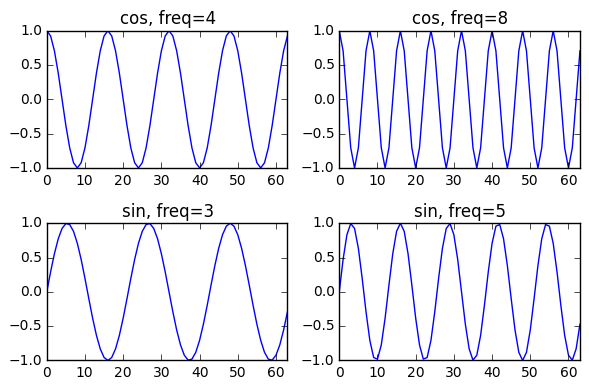

In [43]:
cos_4 = basis_function(np.cos, 4, SIGNAL_LENGTH)
cos_8 = basis_function(np.cos, 8, SIGNAL_LENGTH)
sin_3 = basis_function(np.sin, 3, SIGNAL_LENGTH)
sin_5 = basis_function(np.sin, 5, SIGNAL_LENGTH)

plt.subplot(2, 2, 1)
plt.plot(cos_4)
plt.xlim(0, SIGNAL_LENGTH-1)
plt.title('cos, freq=4')

plt.subplot(2, 2, 2)
plt.plot(cos_8)
plt.xlim(0, SIGNAL_LENGTH-1)
plt.title('cos, freq=8')

plt.subplot(2, 2, 3)
plt.plot(sin_3)
plt.xlim(0, SIGNAL_LENGTH-1)
plt.title('sin, freq=3')

plt.subplot(2, 2, 4)
plt.plot(sin_5)
plt.xlim(0, SIGNAL_LENGTH-1)
plt.title('sin, freq=5')

plt.tight_layout()
plt.show()

Looks like it does! Now let's look at the output of the DFT() function applied to the first random signal.

In [44]:
ReX, ImX = DFT(signal_a)
print(ReX)
print(ImX)

[33.882719158675791, 0.21010414683370715, -0.059885815401861997, 1.7508019442820171, 1.2093620480577365, 1.9642143610039908, 0.049275368699785993, -0.063797393467865504, 1.3854317572693489, -1.0227350250767082, 0.26636904301756748, -0.58781652350319114, 1.0267495421249038, -0.0090327527512497618, 0.30956912253174873, -3.3356246104015796, 2.6942646087740356, 0.19084106049043603, 2.2902429942744171, -2.3195530063954575, -0.32827275841056042, -1.8093905390689435, -0.83433820942954062, 1.6784003370415839, 0.013613759811705317, 1.2914007517268593, 3.9171661597439145, -0.14017061110756701, -0.41184307116566177, 1.6153585880760271, -0.36454728718941909, -1.2287466601490669, 0.36137436274985824]
[0.0, -2.2283840494116873, -0.45807433636462447, -2.2313074006568656, 1.9944376548500253, -0.41856515189104038, -0.40363636956937149, 0.40401166406739375, -0.2217523998015184, 3.2323180687705784, -3.598819280417783, 0.56427056287884203, -2.7313055793970027, 0.81567051941803226, -0.50846645769358123, -0

This is near-impossible to interpret, of course. Plotting these makes it somewhat better:

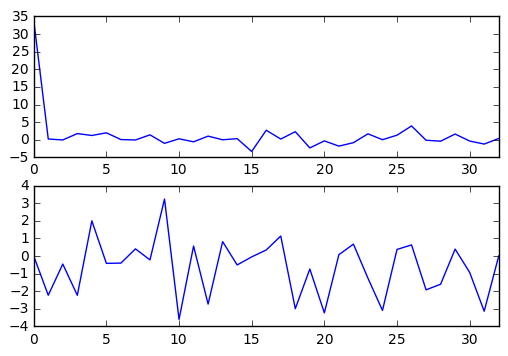

In [45]:
plt.subplot(2, 1, 1)
plt.plot(ReX)
plt.xlim(0, len(ReX)-1)

plt.subplot(2, 1, 2)
plt.plot(ImX)
plt.xlim(0, len(ImX)-1)

plt.show()

Somewhat better; one can now see, for example, that the sine waves with frequency 0 and 32 equals 0. This is in fact always the case, which is why the DFT function could simply skip correlating the input signal with a sine function with those frequencies. 

Additionally, one can see that the first entry in ReX, i.e. the amplitude corresponding to the cosine function that completes 0 cycles over the signal length and is thus constantly equal to 1 (since cos(0) = 1), contains the average of the signal. The value appears to be approximately 30. This makes sense since the amplitudes have not yet been normalized; if one were to do that, ReX[0] would roughly equal 0.5 which should indeed be the average of signal_a since the rnd.random() produces values within the interval [0, 1] with uniform probability.

The above-shown visualization of the cosine and sine wave functions is called rectangular representation. There is another way to visualize these amplitudes that makes interpretation significantly easier: the so-called polar representation.

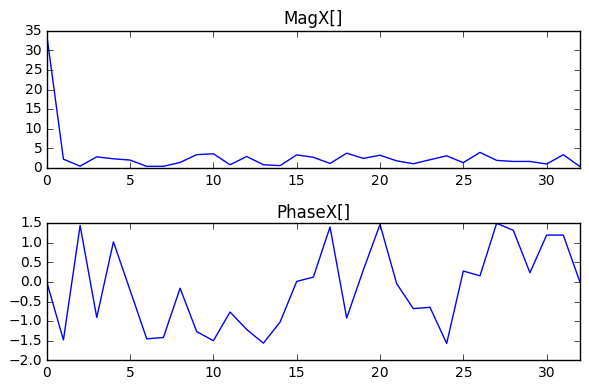

In [49]:
def polar_representation(ReX, ImX):
    MagX = [0. for frequency in range(len(ReX))]     # the magnitude of a new set of cosine functions
    PhaseX = [0. for frequency in range(len(ReX))]   # the phase shift of the cosine functions
    for frequency in range(len(ReX)):
        MagX[frequency] = np.sqrt(ReX[frequency]**2 + ImX[frequency]**2)
        PhaseX[frequency] = np.arctan(ImX[frequency] / ReX[frequency])
    return(MagX, PhaseX)

MagX, PhaseX = polar_representation(ReX, ImX)

plt.subplot(2, 1, 1)
plt.plot(MagX)
plt.title('MagX[]')
plt.xlim(0, len(MagX)-1)

plt.subplot(2, 1, 2)
plt.plot(PhaseX)
plt.title('PhaseX[]')
plt.xlim(0, len(PhaseX)-1)

plt.tight_layout()
plt.show()

The polar representation through the arrays MagX and PhaseX contains the same information as ReX and ImX. Instead of containing the amplitudes of a set of cosine and sine functions, however, it represents this information through an array of amplitudes for cosine functions with a given frequency, as well as these cosine functions' phase shifts. The polar representation is usually better-suited to analyze the frequencies contained in a signal.

As the input signal was produced via a random process, the magnitude spectrum does not show any frequency being particularly dominant in the signal with only the DC component (i.e., the average) being substantially greater than 5.

To finish off this part, one can use the inverse DFT to reconstruct the original signal through the basis functions and their respective amplitudes. For this, using the rectangular representation is required.

In [59]:
def inverse_DFT(ReX, ImX):
    cos_basis_funcs = {frequency: basis_function(np.cos, frequency, len(ReX)*2-2) for frequency in range(int(len(ReX)))}
    sin_basis_funcs = {frequency: basis_function(np.sin, frequency, len(ImX)*2-2) for frequency in range(int(len(ImX)))}
    signal_length = len(cos_basis_funcs[0])
    frequencies = sorted(cos_basis_funcs.keys())
    for frequency in frequencies[1:-1]:
        ReX[frequency] *= (2/signal_length)
        ImX[frequency] *= (2/signal_length)
    ReX[0] *= (1/signal_length)
    ReX[-1] *= (1/signal_length)
    
    synthesized_signal = [0. for n in range(signal_length)]
    for n in range(signal_length):
        x_n = 0
        for frequency in frequencies:
            x_n += ReX[frequency] * cos_basis_funcs[frequency][n]
            x_n += ImX[frequency] * sin_basis_funcs[frequency][n]
        synthesized_signal[n] = x_n
    return(synthesized_signal)

synthesized_signal = inverse_DFT(ReX, ImX)

Let's see if the synthesized signal truly matches the original input signal:

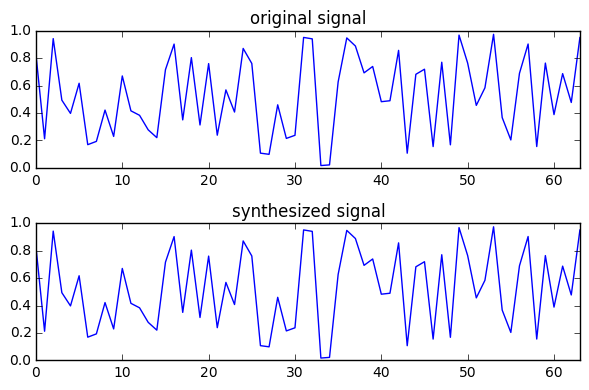

In [61]:
plt.subplot(2, 1, 1)
plt.plot(signal_a)
plt.xlim(0, SIGNAL_LENGTH-1)
plt.title('original signal')

plt.subplot(2, 1, 2)
plt.plot(synthesized_signal)
plt.xlim(0, SIGNAL_LENGTH-1)
plt.title('synthesized signal')

plt.tight_layout()
plt.show()

Indeed, they are identical. 

To be added next to this notebook:
- complex DFT
- Fast Fourier Transform